# Simple example illustrating basic aspects of ridge linear regression

In [13]:
# Uncomment to upgrade packages
#!pip3 install pandas --upgrade --user --quiet 
#!pip3 install numpy --upgrade --user --quiet 
#!pip3 install scikit-learn --upgrade --user --quiet

In [1]:
import numpy as np
import pandas as pd

pd.set_option('display.precision', 4)

## 1. Load `murders.txt` data from class

In [3]:
df = pd.read_csv('../data/murders.txt', sep=' ')
df['x_0'] = 1
print(df.head())

   inhabitants  poverty  unemployment  murders  x_0
0          587     16.5           6.2     11.2    1
1          643     20.5           6.4     13.4    1
2          635     26.3           9.3     40.7    1
3          692     16.5           5.3      5.3    1
4         1248     19.2           7.3     24.8    1


In [4]:
# put data into X matrix and y column

X = df[['x_0', 'inhabitants', 'poverty', 'unemployment']].to_numpy()
y = df[['murders']].to_numpy()

print(X.shape, y.shape)

(20, 4) (20, 1)


## 2. Train/test split for later validation

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(13, 4) (13, 1)
(7, 4) (7, 1)


## 3. Preprocessing: first normalize training set, then apply same transformation to test

In [6]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)   # computes means and stdevs for each column in X_train
X_train_scaled = scaler.transform(X_train)             # substracts mean and divides by stdev (estimated from training)
X_test_scaled = scaler.transform(X_test)               # substracts mean and divides by stdev (estimated from training)

X_train_scaled[:,0] = 1   # undo transformation for all-1 column
X_test_scaled[:,0] = 1   # undo transformation for all-1 column

print(X_train_scaled.mean(axis=0))
print(X_test_scaled.mean(axis=0))

[ 1.00000000e+00  6.83214169e-17 -5.44436291e-16  1.70803542e-16]
[ 1.          2.26114699 -0.15256269 -0.21991089]


As expected, the means of the training dataset are zero, because the `scaler` was fit using those, but the test dataset isn't. In a larger-scale example, we would expect both to closely resemble zero.

## 4. Train ridge regression model for several $\lambda$ values

As explained in class, for each value of $\lambda$ that we want to try, 
we use _maximum a posteriori_ method to find linear coefficients $\theta_0, \theta_1, ..$:

$$\theta_{ridge} = (X^T X + \lambda I)^{-1} X^T y$$

### train model, using formulas from slides

1. For each $\lambda\in\Lambda$:
    - compute optimal solution $\hat{\mathbf{\theta}}_{\lambda} = (\mathbf{X}^T\mathbf{X} + \lambda I)^{-1}\mathbf{X}^T\mathbf{y}$ 
    - compute "hat" matrix $H_{\lambda} = \mathbf{X}(\mathbf{X}^T\mathbf{X} + \lambda I)^{-1}\mathbf{X}^T$
    - compute loocv directly for each $\lambda$ (no need to use folds etc.):

    $$loocv(\lambda) = \frac{1}{n} \sum_{i=1}^n \left( \frac{y_i - \mathbf{x}_i \mathbf{\theta}_{\lambda}}{1 - h_{ii}}  \right)^2$$
    
2. Return $\lambda$ with minimum *loocv*


In [7]:
from sklearn.metrics import mean_squared_error

lambdas = np.logspace(start = -4, stop = 1.1, num = 100, base = 10.0)
results = []
X = X_train_scaled.copy()
y = y_train.copy()
n = y.shape[0]
d = X.shape[1]

XtX = X.T @ X # To save on some computations, we'll calculate this once
for l in lambdas:
    XtX_inv = np.linalg.inv( XtX + l * np.identity(n=d))
    coefs = (XtX_inv) @ X.T @ y
    hatmat = X @ XtX_inv @ X.T
    trace_hatmat = np.trace(hatmat)
    y_pred = X @ coefs
    loocv = 1/n * np.sum([((y[i] - y_pred[i]) / (1 - hatmat[i,i]))**2 for i in range(n)])
    mse = mean_squared_error(y, y_pred)
    gcv = mse / (1 - trace_hatmat/n)**2
    results.append([l, mse, loocv, gcv])

df = pd.DataFrame(results, columns = ['lambda', 'training_mse', 'loocv', 'gcv']) 
df.sort_values(by='loocv')


,lambda,training_mse,loocv,gcv
77,0.9261,11.1143,19.3411,20.2950
78,1.0428,11.7132,19.3900,21.1709
76,0.8225,10.6249,19.5544,19.5926
79,1.1741,12.4449,19.7541,22.2551
75,0.7305,10.2258,19.9813,19.0339
...,...,...,...,...
95,7.8332,82.5775,120.1984,118.2082
96,8.8197,94.1640,135.1295,132.5608
97,9.9305,106.9429,151.1217,148.0363
98,11.1811,120.9006,168.0884,164.5523


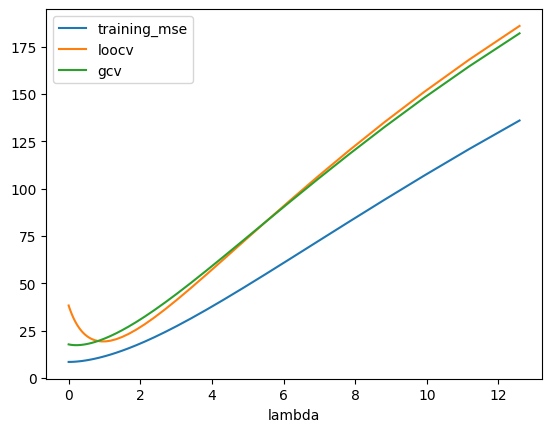

In [8]:
df.plot(kind='line', x='lambda');

### select best lambda according to loocv; re-train on the whole training set to obtain model using best lambda

In [9]:
best_lambda = df.loc[df['loocv'].idxmin()]['lambda']

print(f'best lambda value: {best_lambda:.4f}')

# apply formula with "best lambda"
theta_vector = np.linalg.inv( X_train_scaled.T @ X_train_scaled + best_lambda * np.identity(n=d)) @ X_train_scaled.T @ y


best lambda value: 0.9261


### as a sanity check, see what RidgeRegressionCV from scikit-learn obtains as best lambda

In [10]:
from sklearn.linear_model import RidgeCV

print(f'there are {X_train_scaled.shape[0]} training examples.')
results = []
for k in range(2, 6+1):
    ridge = RidgeCV(alphas=lambdas, fit_intercept=False, cv=k)   #k-fold cross-val
    clf = ridge.fit(X_train_scaled, y_train)
    results.append([k, clf.alpha_])

## "efficient"  way:
ridge = RidgeCV(alphas=lambdas, fit_intercept=False, cv=None)
clf = ridge.fit(X_train_scaled, y_train)
results.append(['efficient', clf.alpha_])

pd.DataFrame(results, columns=['cross-val method (k)', 'best lambda'])

there are 13 training examples.


,cross-val method (k),best lambda
0,2,0.8225
1,3,0.9261
2,4,1.1741
3,5,0.8225
4,6,0.7305
5,efficient,0.9261


## 4. Test trained linear model to predict `murders` on __unseen data__  (test partition)

In [11]:
# make predictions on unseen test points (from test partition)
y_pred = X_test_scaled @ theta_vector

# compute squared error for each example
abs_error = np.abs(y_pred - y_test)
sq_error = np.square(y_pred - y_test)

# show them in table
dict_data = {'target': y_test.ravel(), 'pred': y_pred.ravel(), 'abs_error': abs_error.ravel(), 'squared_error': sq_error.ravel()}
df = pd.DataFrame.from_dict(dict_data)
print(df)

print(f'\nThe TEST mean squared error is: {mean_squared_error(y_pred, y_test)}')

   target     pred  abs_error  squared_error
0    21.7  27.6167     5.9167        35.0073
1    13.4  16.1888     2.7888         7.7771
2    25.7  21.5409     4.1591        17.2980
3     8.7   4.1998     4.5002        20.2517
4    14.5  30.5809    16.0809       258.5966
5    25.8  31.8522     6.0522        36.6287
6    20.9  19.3787     1.5213         2.3143

The TEST mean squared error is: 53.98196637762697


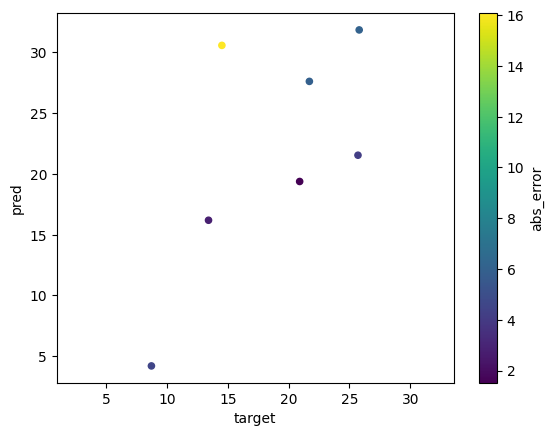

In [12]:
ax = df.plot.scatter(x='target', y='pred', c='abs_error');
ax.axis('equal');
